In [1]:
import tensorflow as tf
import os

2024-06-16 09:05:09.937188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 09:05:09.937255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 09:05:09.938892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### This is my first iteration of training GANS to generate anime faces 

In [2]:
tf.__version__

'2.15.0'

In [3]:
imgs =[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        imgs.append(os.path.join(dirname, filename))
        
print(f"Found {len(imgs)} images.")

Found 63565 images.


In [4]:
# imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir)]
imgs = imgs[20000:]
len(imgs)

43565

### Using only 43k images
Also I defineD the preprocess func toconvert the string files to tf tensor,resizing and normalizing

In [5]:
batch_size = 128
training_data = tf.data.Dataset.from_tensor_slices(imgs)
img_size = 64

def preprocess_image(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image  = tf.cast(image,tf.float32) 
    
    image = tf.image.resize(image, size=(img_size, img_size))
    image = (image / 127.5) - 1.0 
    
    
    return image

training_data = training_data.map(preprocess_image)
training_data = training_data.shuffle(buffer_size=len(training_data)).batch(batch_size)


In [6]:
len(training_data)

341

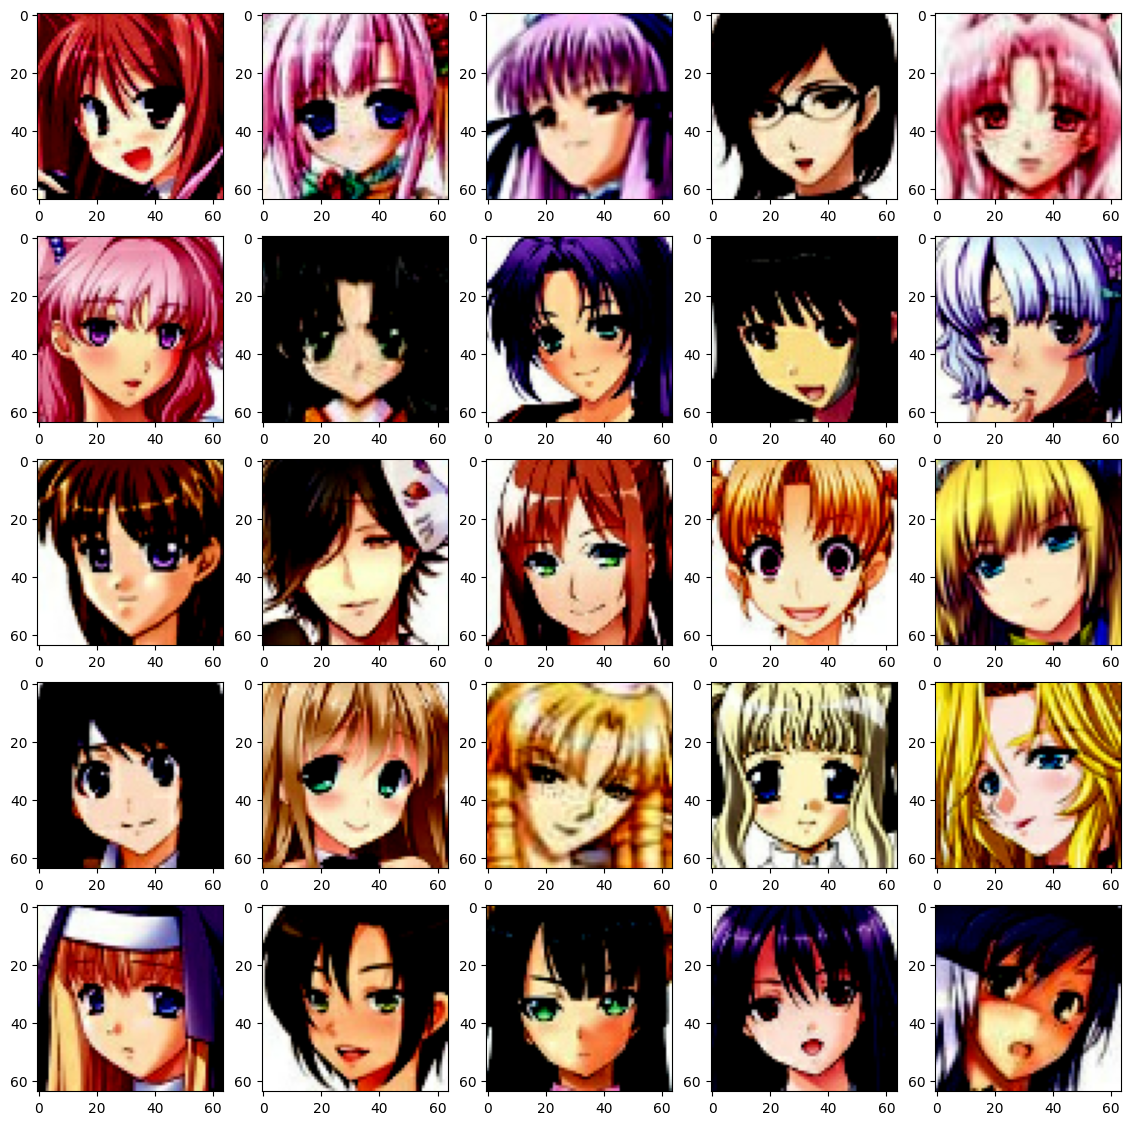

In [7]:
import matplotlib.pyplot as plt
fig,axes =plt.subplots(5,5,figsize=(14,14))
sample = training_data.unbatch().take(25)
# print(sample)
sample = [im for im in sample]
idx =0
for i in range(5):
    for j in range(5):
        axes[i,j].imshow(sample[idx])
        idx+=1




In [8]:
from tensorflow.keras import layers, models
noise_dim = 128

In [9]:
init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU, PReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

### Function to return the generator  and discriminator model. In this architecture I used large kernels ie..5*5 to study its effects on generated image. Later in iter 2 I used mixture of smaller and larger kernels.

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)  # Note: None is the batch size

    # First Conv2DTranspose layer, upsampling to 16x16
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second Conv2DTranspose layer, upsampling to 32x32
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third Conv2DTranspose layer, upsampling to 64x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final Conv2DTranspose layer, producing the output with shape (64, 64, 3)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)


    return model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


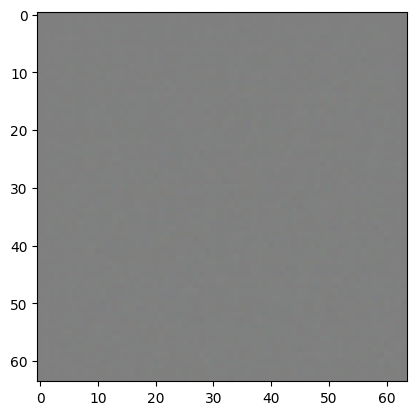

In [16]:
seed_size = 128
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :,:]*0.5 +0.5)

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()

     # Block - 1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second Conv2D layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third Conv2D layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [18]:
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

NUM_ROWS = 4  
NUM_COLS = 7
MARGIN = 16
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00136727]], shape=(1, 1), dtype=float32)


In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Defining losses 

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1 = 0.5)

In [29]:
EPOCHS = 25





In [30]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [31]:
disc_losses = []
gen_losses = []
def train(dataset, epochs):
  
  for epoch in range(epochs):
    g_loss = 0
    d_loss = 0
    num_batches = 0
    
    for image_batch in dataset:
      gen_loss,disc_loss = train_step(image_batch)  
      g_loss += gen_loss
      d_loss += disc_loss
      num_batches += 1
        
    g_loss /= num_batches
    d_loss /= num_batches

    gen_losses.append(g_loss)
    disc_losses.append(d_loss)
    
    generate_and_save_images(generator,epoch + 1,seed)
    
  generate_and_save_images(generator,epochs,seed)



In [32]:

num_examples_to_generate = 16


seed = tf.random.normal([num_examples_to_generate, noise_dim])
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
#   test_images = tf.map_fn(preprocess_image, test_input)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :]* 0.5 + 0.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

2024-06-16 09:11:01.354636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-16 09:12:02.769591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


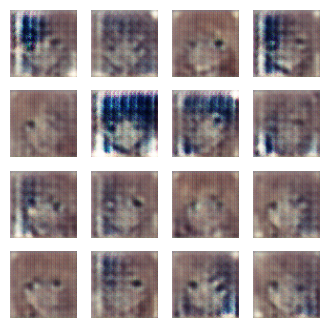

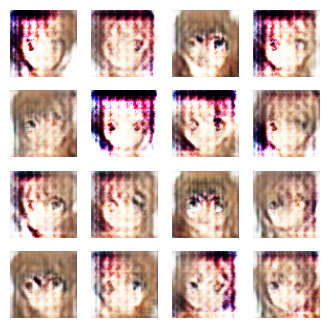

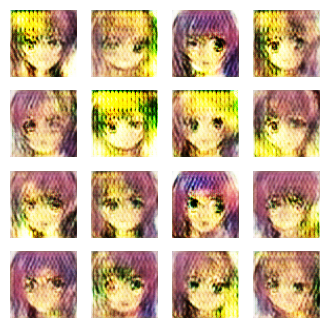

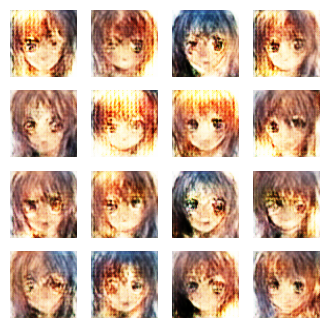

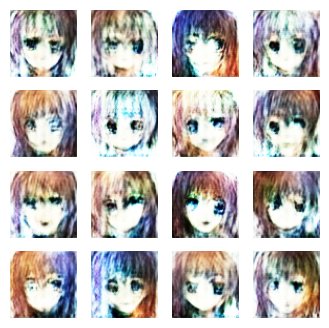

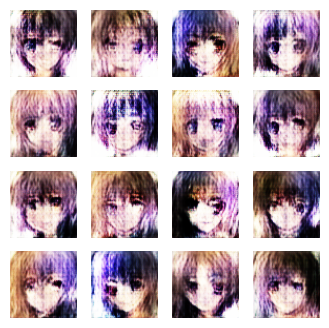

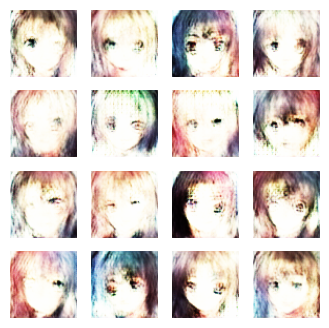

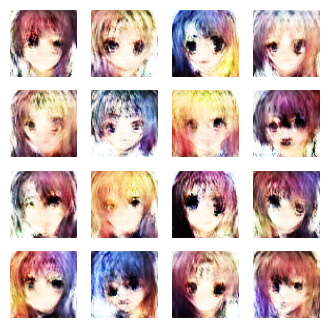

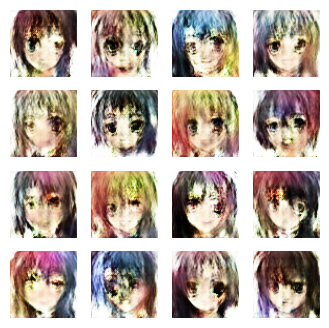

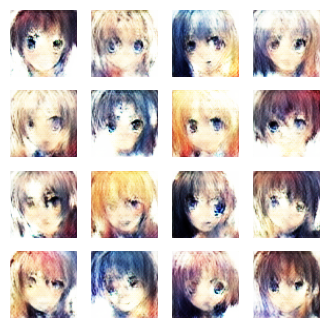

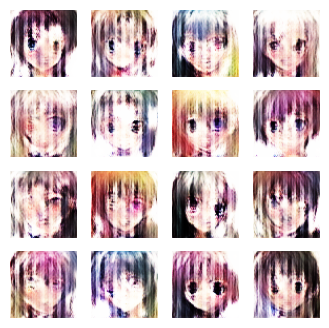

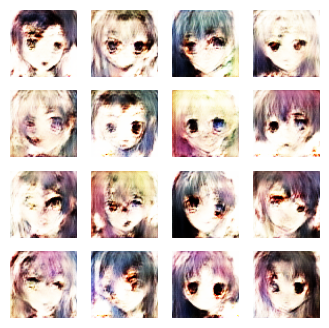

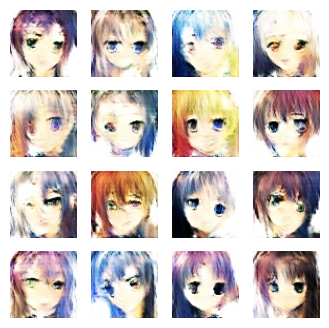

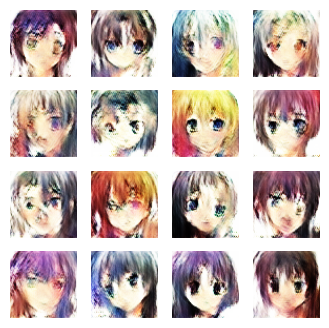

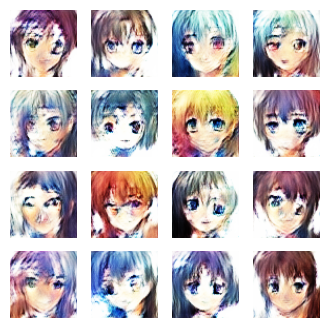

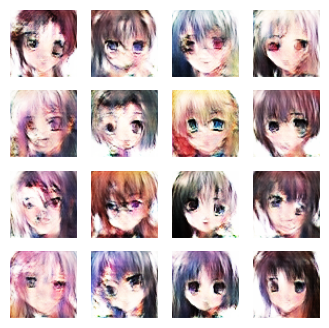

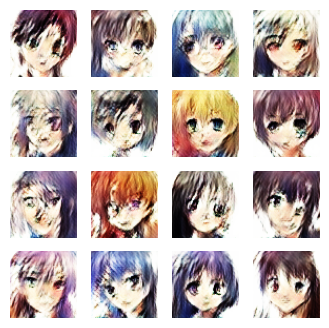

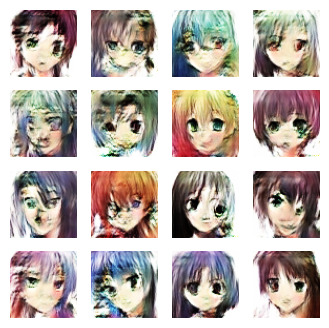

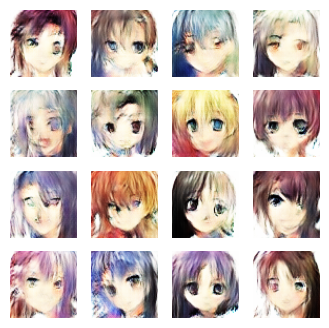

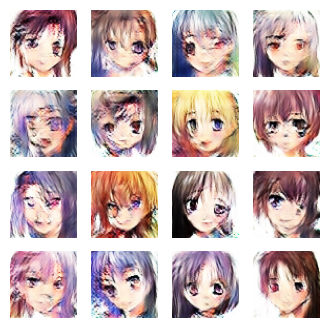

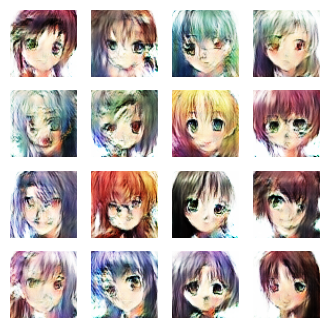

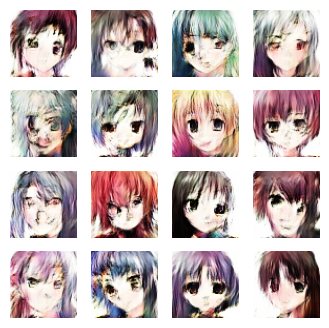

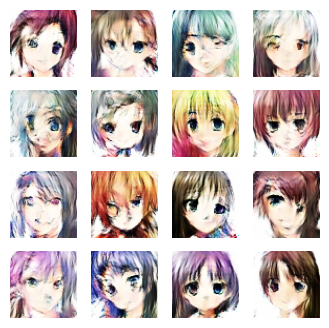

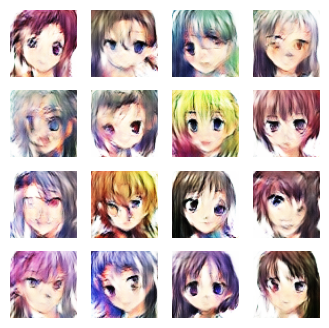

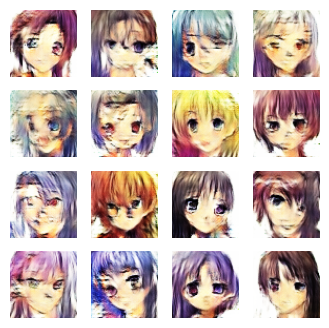

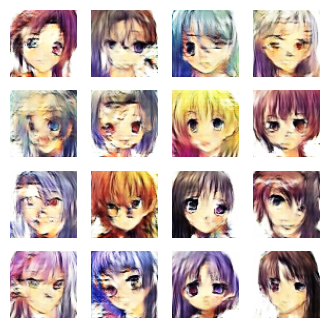

In [33]:
train(training_data, EPOCHS)

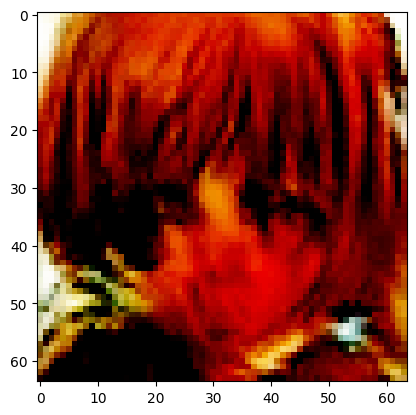

In [44]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow((generated_image[0, :, :, :] ))

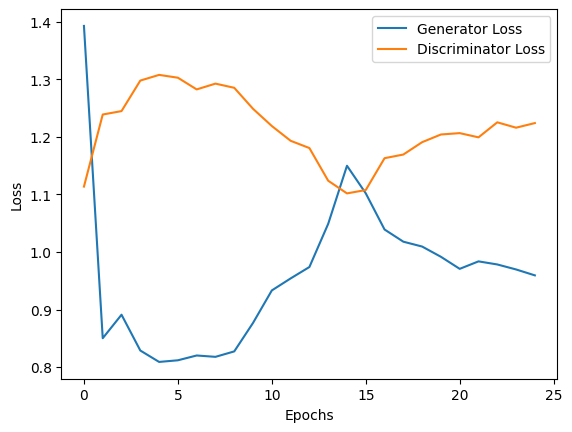

In [38]:
plt.figure()
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### After training as we can see the generated images are good but not great. Thats the reason I added mixture of larger and smaller kernels in iter2 notebook.

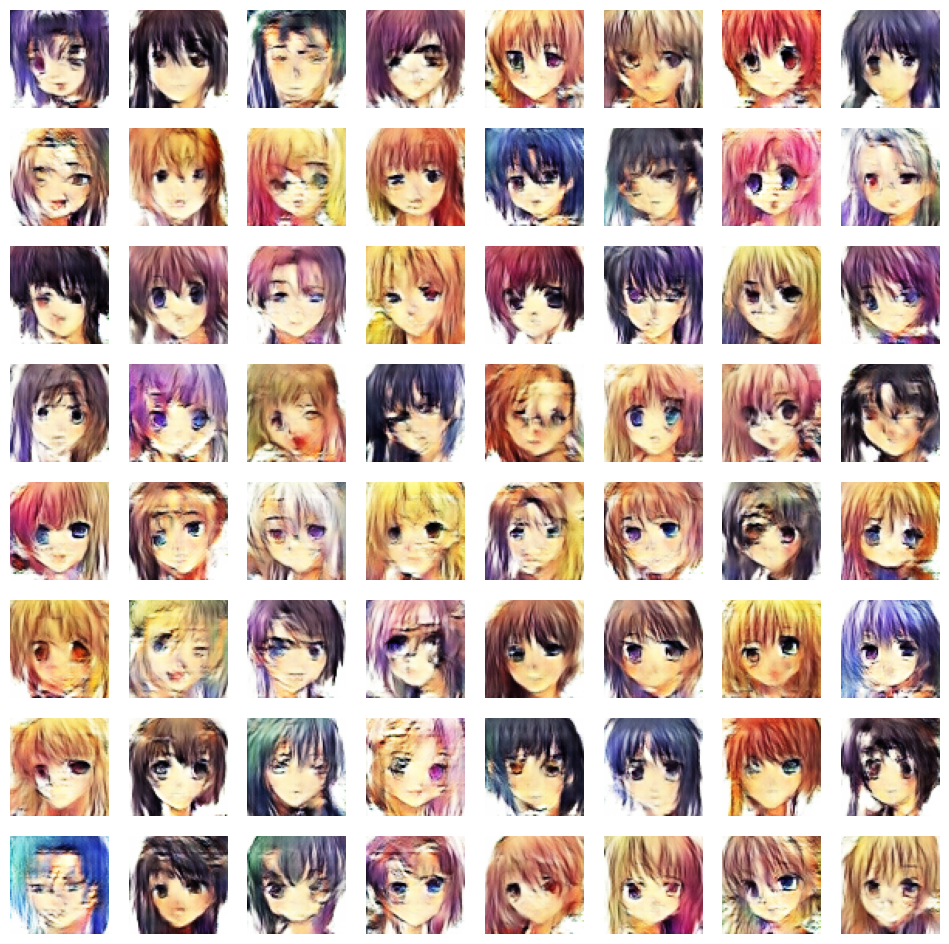

In [45]:
def generate_faces():
    """Generates random Anime faces"""
    
    # generate 64 images by giving 64 inputs
    noise = tf.random.normal([64,128])
    generated_images = generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        # Convert to range [0,1] for plt.imshow()
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()
    
generate_faces()

In [41]:
min_gen_loss = 1e9
min_disc_loss = 1e9

for i in gen_losses:
    min_gen_loss = min(min_gen_loss,i)
    
for j in gen_losses:
    min_disc_loss = min(min_disc_loss,j)
    
    
print(f"min generator loss : {min_gen_loss}")
print(f"min discriminator loss : {min_disc_loss}")
    

min generator loss : 0.8089489340782166
min discriminator loss : 0.8089489340782166


### Generator Model

#### Filters
- **Number of Filters:**
  - More filters capture detailed features but increase computational complexity.
  - Too few: Images lack detail and appear blurry.
  - Too many: Risk of overfitting and reduced diversity.

#### Kernel Size
- **Kernel Size:**
  - Defines the receptive field.
  - Small (3x3): Capture fine details.
  - Large (5x5, 7x7): Capture more context but increase computational load.

#### Strides
- **Strides:**
  - Control the upsampling rate.
  - Small (1): Gradual and detailed image generation, higher quality.
  - Large (2): Faster upsampling, potential artifacts and checkerboard patterns.

### Discriminator Model

#### Filters
- **Number of Filters:**
  - Affects feature capture and computational cost.
  - Too few: Poor feature capture, weak feedback.
  - Too many: Increased cost, risk of overfitting.

#### Kernel Size
- **Kernel Size:**
  - Affects feature scale capture.
  - Small (3x3): Capture fine details.
  - Large (5x5, 7x7): Capture broader context, risk of smoothing out details.

#### Strides
- **Strides:**
  - Control downsampling rate.
  - Small (1): Preserve spatial information, detect subtle differences.
  - Large (2): Faster downsampling, potential to miss details.


## Further I trained the mixture of smaller and larger kernel architecture on more epochs . the results were great.
I have shared iter2 notebook as well with changes as discussed above